# Writing a custom Backend

Adding data to a database requires that this data is stored in some kind of file. `MADAS` uses an abstract class, the `Backend`, to describe interactions with the database file. This - on the one hand - allows users to use `MADAS` without knowing about database files. On the other hand, it allows users to create their own `Backend`s based on their requirements. Such requirements could be, e.g., that an already existing database should be used, or a certain level of performance is needed.

In this tutorial you are going to learn how to:

<div class="alert alert-block alert-warning">
    
**[Find the required methods](#Find-the-required-methods)**

**[A text-file based database](#A-text-file-based-database)**

**[Writing a class](#Writing-a-class)**

**[Testing](#Testing)**
   
</div>

Let's get started!

In [1]:
#imports
from madas import Material
from madas.backend import Backend

## Find the required methods

We can inspect wich methods are defined for the `Backend` base class. The documentation provides most of the required information to start implementing our own `Backend`.

In [2]:
help(Backend)

Help on class Backend in module madas.backend.backend_core:

class Backend(builtins.object)
 |  Backend(filename='materials_database.db', filepath='data', make_dirs=True, key_name='mid', log=None)
 |  
 |  A database backend wrapper to unify file-based storage of materials data. 
 |  
 |  **Keyword arguments:**
 |  
 |  filename: `str`
 |      Name of the data file
 |  
 |      default: `"materials_database.db"`
 |  
 |  filepath: `str`
 |      Path (location) of the file.
 |  
 |      default: `"data"`
 |  
 |  make_dirs: `bool`
 |      Create directory paths if it does not exist.
 |  
 |      default: `True`
 |  
 |  key_name: `str`
 |      Name of unique keys that are used to find (individual) entries in the database.
 |  
 |      default: `"mid"`
 |  
 |  log: `logging.Logger` or `None`
 |      Logger used displaying logs. 
 |  
 |      default: `None`
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename='materials_database.db', filepath='data', make_dirs=True, key_name=

## A text-file based database

For this tutorial, we will write a simple 'database', that stores one material in each line of a text file.  
**Note** that this implementation is **neither efficient, nor safe from data loss** and is meant **only for demonstration purposes**.

We will write the individual methods that are required for our `Backend` consecutively and then combine them in a new class. Eventually, we test the implementation with real data.

### Preparations

Our file will contain a serialized `Material` class on each line, which can be accessed using the database index.

We will use a single text file called `tutorial_backend_development_file.txt` for demostration purposes. For simplicity, we will omit storing the database metadata.

In [3]:
# Define a filename
TUTORIAL_FILE_NAME='tutorial_backend_development_file.txt'

We also need some test data to develop our methods. We will generate some synthetic `Material` objects for this purpose.

In [4]:
from ase.build import bulk
from madas import Material

tutorial_test_material1 = Material("test_material1", atoms=bulk("Ag"), data={"test":"data1"})
tutorial_test_material2 = Material("test_material2", atoms=bulk("Au"), data={"test":"data2\nor something"})
tutorial_test_material3 = Material("test_material3", atoms=bulk("Cu"), data={"test":"data3"})

### Adding data

Adding data to a text file can be achieved by using the [built-in Python methods](https://docs.python.org/3.10/tutorial/inputoutput.html#reading-and-writing-files). Below, comments are added to explain each line of the code. 

#### add_single

In [5]:
import json

# open the file
with open(TUTORIAL_FILE_NAME, "a") as f_:
    # convert the material to a dictionary and dump the latter as json data
    # this data is then written to file
    f_.write(json.dumps(tutorial_test_material1.to_dict()))
    # add newline, such that each material is in its own line
    f_.write("\n")

In [6]:
# We can show the contents of our database file using the Bash functionality of Jupyter
!cat tutorial_backend_development_file.txt

{"mid": "test_material1", "atoms": {"numbers": [47], "positions": [[0.0, 0.0, 0.0]], "cell": [[0.0, 2.045, 2.045], [2.045, 0.0, 2.045], [2.045, 2.045, 0.0]], "pbc": [true, true, true]}, "properties": {}, "data": {"test": "data1"}}


#### add_many

To add several materials, we can just repeat the step above:

In [7]:
with open(TUTORIAL_FILE_NAME, "a") as f_:
    for material in [tutorial_test_material2, tutorial_test_material3]:
        f_.write(json.dumps(material.to_dict()))
        f_.write("\n") # add newline, such that each material is in its own line

In [8]:
!cat tutorial_backend_development_file.txt

{"mid": "test_material1", "atoms": {"numbers": [47], "positions": [[0.0, 0.0, 0.0]], "cell": [[0.0, 2.045, 2.045], [2.045, 0.0, 2.045], [2.045, 2.045, 0.0]], "pbc": [true, true, true]}, "properties": {}, "data": {"test": "data1"}}
{"mid": "test_material2", "atoms": {"numbers": [79], "positions": [[0.0, 0.0, 0.0]], "cell": [[0.0, 2.04, 2.04], [2.04, 0.0, 2.04], [2.04, 2.04, 0.0]], "pbc": [true, true, true]}, "properties": {}, "data": {"test": "data2\nor something"}}
{"mid": "test_material3", "atoms": {"numbers": [29], "positions": [[0.0, 0.0, 0.0]], "cell": [[0.0, 1.805, 1.805], [1.805, 0.0, 1.805], [1.805, 1.805, 0.0]], "pbc": [true, true, true]}, "properties": {}, "data": {"test": "data3"}}


### Getting data

Getting data is based on the `mid` of a `Material`. We can find the corresponding line using a linear search.

#### get_single

In [9]:
TEST_MID = "test_material1"

with open(TUTORIAL_FILE_NAME, "r") as f_:
    for new_line in f_:
        # deserialize every material to check its mid
        material = Material.from_dict(json.loads(new_line))
        if material.mid == TEST_MID:
            break

In [10]:
material

Material(mid = test_material1, data = {'test'}, properties = set())

#### get_many

For a set of different mids, this can be optimized in order to reduce searches:

In [11]:
TEST_MIDS = ["test_material3", "test_material1"]

# here we use a set to simplify checking if a material has been found
mids_to_search = set(TEST_MIDS)
found_materials = []
with open(TUTORIAL_FILE_NAME, "r") as f_:
    for new_line in f_:
        # stop search if all materials have been found
        if len(mids_to_search) == 0:
            break
        material = Material.from_dict(json.loads(new_line))
        # if the current material is one of the searched ones
        if material.mid in mids_to_search:
            # append then to the results
            found_materials.append(material)
            # discard the entry from the list of materials
            mids_to_search.discard(material.mid)
    # sort to recover input sorting
    found_materials = sorted(found_materials, key=lambda x: TEST_MIDS.index(x.mid))

In [12]:
found_materials

[Material(mid = test_material3, data = {'test'}, properties = set()),
 Material(mid = test_material1, data = {'test'}, properties = set())]

#### get_by_id

To get an entry by database id, we just iterate through the lines of the file.

In [13]:
TEST_ID = 1

with open(TUTORIAL_FILE_NAME, "r") as f_:
    for idx, new_line in enumerate(f_):
        if idx==TEST_ID:
            material = Material.from_dict(json.loads(new_line))

In [14]:
material

Material(mid = test_material2, data = {'test'}, properties = set())

#### get_length

To get the number of entries in our database, we can count the number of lines:

In [15]:
with open(TUTORIAL_FILE_NAME, "r") as f_:
    length = sum(1 for _ in f_)

In [16]:
length

3

#### has_entry

Because we are using a text file for storing, to check if an entry is present we have to iterate through all entries of the file.

In [17]:
mid=TEST_MID

is_in_db=False
with open(TUTORIAL_FILE_NAME, "r") as f_:
    for new_line in f_:
        if json.loads(new_line)["mid"]==mid:
            is_in_db=True
            break
print(is_in_db)

True


### Updating entries

Updating entries is more complicated, because we have to overwrite our original file. Here, we store the file content in memory instead.

#### update_single

In [18]:
mid=TEST_MID
updated_data = {"test":"up"}

# read the full file as a list of strings
with open(TUTORIAL_FILE_NAME, "r") as f_:
    contents = f_.readlines()    

# change the respective entry
for idx in range(len(contents)):
    material = Material.from_dict(json.loads(contents[idx]))
    if material.mid == mid:
        material.properties.update(**updated_data)
        contents[idx] = json.dumps(material.to_dict())+"\n"
        break

# overwrite the original file
with open(TUTORIAL_FILE_NAME, "w") as f_:
    f_.writelines(contents)

In [19]:
!cat $TUTORIAL_FILE_NAME

{"mid": "test_material1", "atoms": {"numbers": [47], "positions": [[0.0, 0.0, 0.0]], "cell": [[0.0, 2.045, 2.045], [2.045, 0.0, 2.045], [2.045, 2.045, 0.0]], "pbc": [true, true, true]}, "properties": {"test": "up"}, "data": {"test": "data1"}}
{"mid": "test_material2", "atoms": {"numbers": [79], "positions": [[0.0, 0.0, 0.0]], "cell": [[0.0, 2.04, 2.04], [2.04, 0.0, 2.04], [2.04, 2.04, 0.0]], "pbc": [true, true, true]}, "properties": {}, "data": {"test": "data2\nor something"}}
{"mid": "test_material3", "atoms": {"numbers": [29], "positions": [[0.0, 0.0, 0.0]], "cell": [[0.0, 1.805, 1.805], [1.805, 0.0, 1.805], [1.805, 1.805, 0.0]], "pbc": [true, true, true]}, "properties": {}, "data": {"test": "data3"}}


#### update_many

To update many entries at once, we can use the same trick.

In [20]:
mids_to_search=["test_material1", "test_material3"]
updated_data = [{"test":"update1"}, {"test":"update3"}]

with open(TUTORIAL_FILE_NAME, "r") as f_:
    contents = f_.readlines()    
for idx in range(len(contents)):
    material = Material.from_dict(json.loads(contents[idx]))
    if material.mid in mids_to_search:
        for mid_, data_ in zip(mids_to_search, updated_data):
            if mid_ == material.mid:
                material.properties.update(**data_)
                contents[idx] = json.dumps(material.to_dict())+"\n"
with open(TUTORIAL_FILE_NAME, "w") as f_:
    f_.writelines(contents)

In [21]:
!cat $TUTORIAL_FILE_NAME

{"mid": "test_material1", "atoms": {"numbers": [47], "positions": [[0.0, 0.0, 0.0]], "cell": [[0.0, 2.045, 2.045], [2.045, 0.0, 2.045], [2.045, 2.045, 0.0]], "pbc": [true, true, true]}, "properties": {"test": "update1"}, "data": {"test": "data1"}}
{"mid": "test_material2", "atoms": {"numbers": [79], "positions": [[0.0, 0.0, 0.0]], "cell": [[0.0, 2.04, 2.04], [2.04, 0.0, 2.04], [2.04, 2.04, 0.0]], "pbc": [true, true, true]}, "properties": {}, "data": {"test": "data2\nor something"}}
{"mid": "test_material3", "atoms": {"numbers": [29], "positions": [[0.0, 0.0, 0.0]], "cell": [[0.0, 1.805, 1.805], [1.805, 0.0, 1.805], [1.805, 1.805, 0.0]], "pbc": [true, true, true]}, "properties": {"test": "update3"}, "data": {"test": "data3"}}


### Metadata

We leave the implementation out of this tutorial. Possible would be, e.g. the implementation in another file. 

To ignore all metadata related operations, we will implement a function that just `pass`es instead of updating any metadata.

## Writing a class

We can combine all of our previously developed functions in a new class, which can be used seamlessly within the MADAS framework:

In [22]:
import os
from typing import List
import warnings

from madas.backend import Backend
from madas.utils import safe_log

class TXTBackend(Backend):
    """
    Text-file based database to demonstrate the implementation of `Backend` classes in `MADAS`. 
    """

    def __init__(self,
                 filename='materials_database.txt',
                 filepath='data',
                 make_dirs=True,
                 key_name='mid',
                 log=None):
        super().__init__(filename=filename, filepath=filepath, make_dirs=make_dirs, key_name=key_name, log=log)
        if not os.path.exists(self.abs_path):
            with open(self.abs_path, "w") as f_:
                f_.write("")

    ## Add data    
    def add_single(self, material: Material):
        """
        Add a single material to the database.
        """
        with open(self.abs_path, "a") as f_:
            f_.write(json.dumps(material.to_dict()))
            f_.write("\n") # add newline, such that each material is in its own line
    
    def add_many(self, materials: List[Material]):
        """
        Add several materials to the database.
        """
        with open(self.abs_path, "a") as f_:
            for material in materials:
                f_.write(json.dumps(material.to_dict()))
                f_.write("\n") # add newline, such that each material is in its own line

    ## Retrieve data
    def get_single(self, mid: str) -> Material | None:
        """
        Get a single material from the database. 
        """
        material = None
        with open(self.abs_path, "r") as f_:
            for new_line in f_:
                material = Material.from_dict(json.loads(new_line))
                if material.mid == mid:
                    break
        if material is None:
            safe_log(f"Material with mid: {mid} is not contained in database.", self.log)
        return material

    def has_entry(self, mid: str) -> bool:
        """
        Check if a material with a given mid is present in the database.
        """
        is_in_db=False
        with open(self.abs_path, "r") as f_:
            for new_line in f_:
                if json.loads(new_line)["mid"]==mid:
                    is_in_db=True
                    break
        return is_in_db
    
    def get_many(self, mids: List[str]) -> List[Material]:
        """
        Get many materials from the database.
        """
        mids_to_search = set(mids)
        found_materials = []
        with open(self.abs_path, "r") as f_:
            for new_line in f_:
                # stop search early if all materials have been found
                if len(mids_to_search) == 0:
                    break
                material = Material.from_dict(json.loads(new_line))
                if material.mid in mids_to_search:
                    found_materials.append(material)
                    mids_to_search.discard(material.mid)
            # sort to recover input sorting
            found_materials = sorted(found_materials, key=lambda x: mids.index(x.mid))
        if len(found_materials) != len(mids):
            safe_log(f"Number of searched ({len(mids)}) and found ({len(found_materials)}) materials do not match.", logger = self.log)
        return found_materials

    def get_by_id(self, db_id: int) -> Material | None:
        """
        Get an entry by database id.
        """
        material = None
        with open(self.abs_path, "r") as f_:
            for idx, new_line in enumerate(f_):
                if idx==db_id:
                    material = Material.from_dict(json.loads(new_line))
                    break
        return material

    def get_length(self):
        """
        Get the length of the database.
        """
        with open(self.abs_path, "r") as f_:
            length = sum(1 for _ in f_)
        return length

    # Update data
    def update_single(self, mid: str, updated_data: dict):
        """
        Update a single entry.
        """
        with open(self.abs_path, "r") as f_:
            contents = f_.readlines()    
        for idx in range(len(contents)):
            material = Material.from_dict(json.loads(contents[idx]))
            if material.mid == mid:
                material.properties.update(**updated_data)
                contents[idx] = json.dumps(material.to_dict())+"\n"
                break
        with open(self.abs_path, "w") as f_:
            f_.writelines(contents)

    def update_many(self, mids: List[str], updated_data: List[dict]):
        """
        Update many entries.
        """
        with open(self.abs_path, "r") as f_:
            contents = f_.readlines()    
        for idx in range(len(contents)):
            material = Material.from_dict(json.loads(contents[idx]))
            if material.mid in mids:
                for mid_, data_ in zip(mids, updated_data):
                    if mid_ == material.mid:
                        material.properties.update(**data_)
                        contents[idx] = json.dumps(material.to_dict())+"\n"
        with open(self.abs_path, "w") as f_:
            f_.writelines(contents)

    def update_metadata(*args, **kwargs):
        warnings.warn("Saving metadata is not supported by the current Backend.", UserWarning)
        pass

## Testing

To test our implementation, we can use it with together with a `MADAS` `MaterialsDatabase`.

In [23]:
from madas import MaterialsDatabase

We initialize the `MaterialsDatabase` with our custom `Backend`.

In [24]:
db = MaterialsDatabase(backend=TXTBackend())

/tmp/ipykernel_19988/2145170194.py:143: UserWarning: Saving metadata is not supported by the current Backend.
  warnings.warn("Saving metadata is not supported by the current Backend.", UserWarning)


Adding data works as usual:

In [25]:
db.add_material("nsXJ2rebbTL8XJuomZIlntl6_iMK")
db.add_material("iH8jCHxCcYSNysv7E_9OabHZ33qE")

Similarly, it can be retrieved:

In [26]:
db[0]

Material(mid = nsXJ2rebbTL8XJuomZIlntl6_iMK, data = {'archive'}, properties = set())

Fingerprints can be added (testing the `update_entries` function):

In [27]:
db.add_fingerprint("PTE", force_calculate=True)

2024-06-14 14:13:40,660 - materials_database_log - INFO - Generating PTE fingerprints...
2024-06-14 14:13:40,661 - materials_database_log - INFO - Generating "PTE" fingerprints.


  0%|          | 0/2 [00:00<?, ?it/s]

2024-06-14 14:13:40,946 - materials_database_log - INFO - Writing PTE fingerprints to database...
2024-06-14 14:13:41,223 - materials_database_log - INFO - Finished generation of PTE fingerprints.
/tmp/ipykernel_19988/2145170194.py:143: UserWarning: Saving metadata is not supported by the current Backend.
  warnings.warn("Saving metadata is not supported by the current Backend.", UserWarning)


In [28]:
db[0].properties

{'PTE': '{"averaged_PTE_column": 14.8}'}

Reading the updated data works just as expected. Here, we generate a similarity matrix from the fingerprints that were stored in our backend and display it.

In [29]:
similarity_matrix = db.get_similarity_matrix("PTE")

2024-06-14 14:13:41,394 - materials_database_log - INFO - Fingerprints with name "PTE" exist. Reading from database.


  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

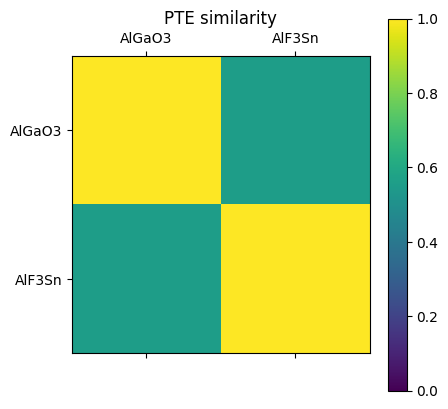

In [31]:
plt.figure()
plt.matshow(similarity_matrix)
plt.xticks(range(len(db)), [entry.atoms.get_chemical_formula() for entry in db])
plt.yticks(range(len(db)), [entry.atoms.get_chemical_formula() for entry in db])
plt.title("PTE similarity")
plt.clim(0,1)
plt.colorbar()
plt.show()